In [1]:
import datasets as ds
from Vocabulary import Vocabulary
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import logging
import itertools
from sklearn.manifold import TSNE
from build_freq_vectors import compute_cooccurrence_matrix,plot_word_vectors_tsne

import random
random.seed(42)
np.random.seed(42)

logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')

class UnimplementedFunctionError(Exception):
	pass

logging.info("Loading dataset")
dataset = ds.load_from_disk("/home/magraz/AI539_NLP/HW1/data/ag_news")
dataset_text =  [r['text'] for r in dataset['train']]
dataset_labels = [r['label'] for r in dataset['train']]

2024-04-15 22:49:57 INFO     Loading dataset


2024-04-15 22:50:04 INFO     Building vocabulary
2024-04-15 22:50:26 INFO     Computing count matrix
2024-04-15 22:50:51 INFO     1416121 non-zero entries in the count matrix
2024-04-15 22:50:51 INFO     Starting GloVe optimization
2024-04-15 22:50:52 INFO     Epoch 1 / 5: learning rate = 0.1
2024-04-15 22:50:52 INFO     Iter 100 / 1382: avg. loss over last 100 batches = 0.3250549948820569
2024-04-15 22:50:52 INFO     Iter 200 / 1382: avg. loss over last 100 batches = 0.11060173440371467
2024-04-15 22:50:52 INFO     Iter 300 / 1382: avg. loss over last 100 batches = 0.08996582114867775
2024-04-15 22:50:53 INFO     Iter 400 / 1382: avg. loss over last 100 batches = 0.08169572138514634
2024-04-15 22:50:53 INFO     Iter 500 / 1382: avg. loss over last 100 batches = 0.07847883414716335
2024-04-15 22:50:53 INFO     Iter 600 / 1382: avg. loss over last 100 batches = 0.07568671164009705
2024-04-15 22:50:53 INFO     Iter 700 / 1382: avg. loss over last 100 batches = 0.07653151190486919
2024-04

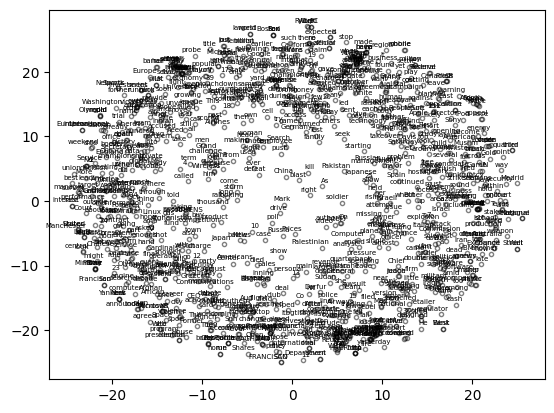

In [2]:
from Vocabulary import Vocabulary
from build_freq_vectors import compute_cooccurrence_matrix, compute_ppmi_matrix, dim_reduce, plot_word_vectors_tsne

window = 80000

logging.info("Building vocabulary")
vocab = Vocabulary(dataset_text[:window])
plt.close()
plt.pause(0.01)


logging.info("Computing count matrix")
C = compute_cooccurrence_matrix(dataset_text[:window], vocab)

########################################################################
# Hyperparmeters and Optimization Variables
########################################################################

d = 32				# dimensionality of the vectors
B = 1024			# batch size (in number of word pairs)
maxEpoch = 5		# maximum number of epochs
learningRate = 0.1	# learning rate / step size for SGD
clip = 50			# gradient clip value 
m = 0.9				# moment parameter

# Initialize word vectors randomly
wordvecs = np.random.rand(vocab.size, d)
contextvecs = np.random.rand(vocab.size, d)

# Initalize biases to approximate occurence frequency
wordbiases = np.log(np.mean(C, axis=1))[:, np.newaxis]
contextbiases = np.log(np.mean(C, axis=0))[:,np.newaxis]

# Create empty variables to store gradients for momentum
wordvecs_momentum = np.zeros( (vocab.size, d) ) 
contextvecs_momentum = np.zeros( (vocab.size, d) ) 
wordbiases_momentum = np.zeros( (vocab.size, 1) ) 
contextbiases_momentum = np.zeros( (vocab.size, 1) ) 

# Get all non-zero word-pair co-occurences
idx = np.vstack(np.nonzero(C)).T
shuf = list(range(idx.shape[0]))
logging.info("{} non-zero entries in the count matrix".format(idx.shape[0]))


logging.info("Starting GloVe optimization")
for epoch in range(maxEpoch):
    
    # Shuffle order that word-pair will be seen
    np.random.shuffle(shuf)

    # Start an epoch
    logging.info("Epoch {} / {}: learning rate = {}".format(epoch+1,maxEpoch, learningRate))
    loss = 0

    # for each batch
    for b in range(idx.shape[0]//B+1):
        
        # Get indexes for word-pairs in the batch
        shuf_idx = shuf[b*B:min((b+1)*B, idx.shape[0])]
        bSize = min((b+1)*B, idx.shape[0])-b*B
        i = idx[shuf_idx, 0]
        j = idx[shuf_idx, 1]

        # Get word and context vectors for pairs in the batch
        w_batch = wordvecs[i, :]
        c_batch = contextvecs[j, :]

        # Compute f(C_i,j) for i,j pairs in batch (Bx1 dimensional vector)
        fval = (np.minimum(1, C[i, j]/100)**0.75)[:,np.newaxis]
        assert fval.shape == (bSize,1), "Incorrect dimension for the vector of weights, should be (batch_size x 1)"

        # Compute error term as (w_i^T c_j + b_i + b_i - log(C_ij)) for each i,j pair in the batch. (Bx1 dimensional vector)
        error = (np.sum(np.multiply(w_batch, c_batch), axis=1)[:,np.newaxis] + wordbiases[i] + contextbiases[j] - np.log(C[i,j])[:,np.newaxis])
        assert error.shape == (bSize,1), "Incorrect dimension for the vector of errors, should be (batch_size x 1)"

        # Combine the overall objective loss
        loss += np.sum(fval*np.square(error))


        ########################################################################
        # Task 3.2
        ########################################################################

        # write expressions using numpy to implement the gradients you derive in 3.1.

        wordvecs_grad = np.zeros( (bSize,d) )
        wordvecs_grad += 2 * fval * c_batch * error

        wordbiases_grad = np.zeros( (bSize,1) )
        wordbiases_grad += 2 * fval * error

        contextvecs_grad = np.zeros( (bSize,d) )
        contextvecs_grad += 2 * fval * w_batch * error

        contextbiases_grad = np.zeros( (bSize,1) )
        contextbiases_grad += 2 * fval * error


        ########################################################################

        assert wordvecs_grad.shape == (bSize,d), "Incorrect dimension, should be (batch_size x d)"
        assert contextvecs_grad.shape == (bSize,d), "Incorrect dimension, should be (batch_size x d)"
        assert wordbiases_grad.shape == (bSize,1), "Incorrect dimension, should be (batch_size x 1)"
        assert contextbiases_grad.shape == (bSize,1), "Incorrect dimension, should be (batch_size x 1)"


        # Update momentum
        wordvecs_momentum *= m
        wordbiases_momentum *= m
        contextvecs_momentum *= m
        contextbiases_momentum *= m

        wordvecs_momentum[i,:] +=  (1-m)*wordvecs_grad
        wordbiases_momentum[i] +=  (1-m)*wordbiases_grad

        contextvecs_momentum[j,:] += (1-m)*contextvecs_grad
        contextbiases_momentum[j] += (1-m)*contextbiases_grad


        # Apply the gradient step (with momentum and gradient clipping)
        wordvecs[i,:] -= np.maximum(np.minimum(learningRate*wordvecs_momentum[i,:], clip),-clip)
        wordbiases[i] -= np.maximum(np.minimum(learningRate*wordbiases_momentum[i], clip),-clip)
        
        contextvecs[j,:] -= np.maximum(np.minimum(learningRate*contextvecs_momentum[j,:], clip),-clip)
        contextbiases[j] -= np.maximum(np.minimum(learningRate*contextbiases_momentum[j], clip),-clip)


        if b % 100 == 0 and b > 0:
            logging.info("Iter {} / {}: avg. loss over last 100 batches = {}".format(b, idx.shape[0]//B, loss/(B*100)))
            loss = 0

logging.info("Building TSNE plot")
plot_word_vectors_tsne(wordvecs, vocab)